## ResNET Training for MDSM
### 1. Instrall required pip package

In [1]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install --upgrade pandas
!pip install --upgrade torchsummary
!pip install --upgrade shap
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


### 2. import required python packages

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import shap
import time, sys
import numpy
import os
import math

from ResNet import Bottleneck, ResNet, ResNet50, ResNet18, ResNet34, ResNet101, ResNet152
from torch.utils.data import Dataset, Subset
from torch.utils.data.dataset import random_split
from torchvision import models
from torchsummary import summary
from datetime import datetime
from pytz import timezone
from IPython.display import clear_output

def is_running_on_ipython():
    try:
        __IPYTHON__
        return True
    except NameError:
        return False
    
#arg[1]
EPOCHS = 200
#arg[2]
BATCH_SIZE = 512
#arg[3]
net_type = "ResNet18"
#arg[4]
split_random = True
#arg[5]
path = ""
display_path = ""

web_running = is_running_on_ipython()

def print_out_hyperparameter():
    print("Hyper-parameter of this Running")
    print(f"Working Path[{display_path}], EPOCHS[{EPOCHS}], BATCH_SIZE[{BATCH_SIZE}], Model[{net_type}], Training data Split[{split_random}]")

if len(sys.argv) >= 2 and web_running == False:
    for i in range(1, len(sys.argv)):
        if i == 1:
            path = sys.argv[i] + "/"
        elif i == 2:
            EPOCHS = int(sys.argv[i])
        elif i == 3:
            BATCH_SIZE = int(sys.argv[i])
        elif i == 4:
            net_type = sys.argv[i]
        elif i == 5:
            split_random = eval(sys.argv[i])

display_path = path;

print_out_hyperparameter()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mdsm_width = 11
mdsm_height = 108
trans_stat = True


now = datetime.now(timezone('Asia/Seoul'))
time_str = now.strftime('%Y-%m-%d_%H%M%S')
hyperparameter_str = "model-{}_epochs-{}-batch-{}-randomsplit-{}-{}".format(net_type, EPOCHS, BATCH_SIZE, split_random, time_str)

data_path = path
if web_running:
    path = path + "results/" + time_str + "_jupyter/"
else:
    path = path + "results/" + time_str + "/"
os.makedirs(path)
os.makedirs(path + "training_metrics")
os.makedirs(path + "check_points")
os.makedirs(path + "graphs")

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Hyper-parameter of this Running
Working Path[], EPOCHS[200], BATCH_SIZE[512], Model[ResNet18], Training data Split[True]


In [3]:
print(device)

cuda


### 3. Define MDSMdata set for torch Dataset and Dataloader and other
* mix_random : For preventing overfitting (Mixing row randomly in MDSM metric
* flip_random : For preventing overfitting (Flip MDSM upside-down)

In [4]:
def mix_random(col, row, mdsm_body):
    size_suffle = random.randint(0,10)
    switchsource = torch.randint(0, row - 1, (size_suffle,))
    temp = np.zeros((1, col), np.float32)
    
    for i in range(0, int(size_suffle)):
        if i == switchsource[i]:
            continue
        temp = mdsm_body[i, :].copy()
        mdsm_body[i, :] = mdsm_body[switchsource[i], :].copy()
        mdsm_body[switchsource[i], :] = temp.copy()
    return torch.tensor(mdsm_body)

def flip_random(col, row, mdsm_body):
    size_suffle = random.randint(0,12)
    if size_suffle % 4 != 0:
        return torch.tensor(mdsm_body)
    
    int_row = int(row)
    for i in range(0, int(int_row / 2)):
        temp = mdsm_body[i, :].copy()
        mdsm_body[i, :] = mdsm_body[int_row - i - 1, :].copy()
        mdsm_body[int_row - i - 1, :] = temp.copy()
    return torch.tensor(mdsm_body)
    
class MDSMDataset(Dataset):
    def __init__(self, mdsmdata_file):
        self.df = pd.read_csv(mdsmdata_file)
        rating = self.df[['ReviewID', 'reviewStar']]
        self.rating = rating.drop_duplicates('ReviewID')
        if trans_stat == True:
            self.height = self.df['ReviewID'].value_counts().max()
        else:
            #Hardcoding for current dataset
            self.height = 108

        mdsm_body = self.df.drop(['reviewNo', 'reviewStar', 'mGNR'], axis=1)
        mdsm_body['imageCnt'] = (mdsm_body['imageCnt'] - mdsm_body['imageCnt'].min())/ (mdsm_body['imageCnt'].max() - mdsm_body['imageCnt'].min())
        mdsm_body['helpfulCnt'] = (mdsm_body['helpfulCnt'] - mdsm_body['helpfulCnt'].mean())/ mdsm_body['helpfulCnt'].std()
        body_height, body_width = mdsm_body.shape;
        self.width = body_width - 1
        mdsm_width = self.width
        if trans_stat == True:
            mdsm_height = self.height
        
        dummy_mdsd = np.zeros((body_height, self.height, self.width), np.float32)
        mdsm_index = np.zeros(self.rating['ReviewID'].max()+1, int)
        mdsm_count = np.zeros(self.rating['ReviewID'].max()+1, int)
        mdsm_index.fill(-1)

        max_index = int(0)
        for index, body in mdsm_body.iterrows():
            dummy_index = max_index
            if mdsm_index[int(body['ReviewID'])] != -1:
                dummy_index = mdsm_index[int(body['ReviewID'])]
            else:
                mdsm_index[int(body['ReviewID'])] = dummy_index
                max_index = max_index + 1

            dummy_mdsd[dummy_index, mdsm_count[dummy_index]] = body.drop('ReviewID')
            mdsm_count[dummy_index] = mdsm_count[dummy_index] + 1

        self.mdsm_body = dummy_mdsd
            
    def __len__(self):
        return self.rating.shape[0]

    
    def __getitem__(self, idx):
        if trans_stat == True:
            _tensor = flip_random(self.width, self.height, self.mdsm_body[idx])
        else:
            _tensor = torch.tensor(self.mdsm_body[idx])
        rtn_tensor = _tensor.unsqueeze(0)
        return rtn_tensor, self.rating.iloc[idx, 1]

### 4. Hyperparameter setting
* epochs, batch_size ResNet layer number
* select ResNet model
* print out Model strucuture

In [5]:
if net_type == "ResNet18":
    net = ResNet18(6, 1).to('cuda')
    print("ResNet18 is used")
elif net_type == "ResNet34":
    net = ResNet34(6, 1).to('cuda')
    print("ResNet34 is used")
elif net_type == "ResNet50":
    net = ResNet50(6, 1).to('cuda')
    print("ResNet50 is used")
elif net_type == "ResNet101":
    net = ResNet101(6, 1).to('cuda')
    print("ResNet101 is used")
elif net_type == "ResNet152":
    net = ResNet152(6, 1).to('cuda')
    print("ResNet152 is used")

summary(net, (1, mdsm_height, mdsm_width))

ResNet18 is used
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 64, 54, 6]           3,136
       BatchNorm2d-2            [-1, 64, 54, 6]             128
              ReLU-3            [-1, 64, 54, 6]               0
         MaxPool2d-4            [-1, 64, 27, 3]               0
            Conv2d-5            [-1, 64, 27, 3]          36,864
       BatchNorm2d-6            [-1, 64, 27, 3]             128
           Dropout-7            [-1, 64, 27, 3]               0
           Dropout-8            [-1, 64, 27, 3]               0
            Conv2d-9            [-1, 64, 27, 3]          36,864
      BatchNorm2d-10            [-1, 64, 27, 3]             128
       BasicBlock-11            [-1, 64, 27, 3]               0
           Conv2d-12            [-1, 64, 27, 3]          36,864
      BatchNorm2d-13            [-1, 64, 27, 3]             128
          Dropout-14  

### 5. Load MDSM dataset from preprocesed csv file
* split train and test dataset into 8:2 ratio
* 6 kinds of classess [0, 1, 2, 3, 4, 5]

In [6]:
print('-- Loading dataset--')

dataset = MDSMDataset(data_path + 'amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized.csv')
#dataset = MDSMDataset(data_path + 'amazon_hmdvr_df_tokenized_sentiment_score_extended.csv')
train_size = round(len(dataset) * 0.8)
test_size = len(dataset) - train_size

-- Loading dataset--


In [7]:

print("Train(", train_size, ") vs Test(", test_size, ")")

print('-- Building train and test dataset / dataloader--')

if split_random:
    print("Training dataset is selected random")
    train_dataset, test_dataset = random_split(dataset, [int(train_size),int(test_size)])
else:
    print("Training dataset is selected fixed")
    train_dataset = Subset(dataset, numpy.arange(1, train_size))
    test_dataset = Subset(dataset, numpy.arange(train_size, len(dataset)))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)

classes = ['0', '1', '2', '3', '4', '5']


Train( 13188 ) vs Test( 3297 )
-- Building train and test dataset / dataloader--
Training dataset is selected random


### 6. Define mae and mse calcuating function

In [8]:
def calcu_metric(outputs, labels):
    mae = abs(outputs - labels)
    mse = torch.pow((outputs - labels), 2)
    mape = abs((outputs-labels)/labels)
    mbe = outputs - labels
    return mae, mse, mape, mbe

### 7. Do ResNet training

In [9]:
print_out_hyperparameter()

criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

correct = 0
total = 0


print('-- Start training : ', EPOCHS, 'epochs')
start = time.time()

mse_history = {'train': [], 'val': []}
rmse_history = {'train': [], 'val': []}
mae_history = {'train': [], 'val': []}
mape_history = {'train': [], 'val': []}
mbe_history = {'train': [], 'val': []}
loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

for epoch in range(EPOCHS):
    losses = []
    
    mse = np.zeros(train_size, np.float32)
    mae = np.zeros(train_size, np.float32)
    mape = np.zeros(train_size, np.float32)
    mbe = np.zeros(train_size, np.float32)
    rmse = np.zeros(train_size, np.float32)
    
    
    val_mse = np.zeros(test_size, np.float32)
    val_mae = np.zeros(test_size, np.float32)
    val_mape = np.zeros(test_size, np.float32)
    val_mbe = np.zeros(test_size, np.float32)
    val_rmse = np.zeros(train_size, np.float32)
    
    metric_index = 0
    
    running_loss = 0
    train_loss = 0
    train_acc = 0
    val_acc = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        outputs = net(inputs)
    
        pred = outputs.data.max(1, keepdim=True)[1]
        train_acc += pred.eq(labels.data.view_as(pred)).sum()
     
    
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss += loss.item()
        
        

        _mae, _mse, _mape, _mbe = calcu_metric(pred.squeeze(), labels)
          #print(_mse.detach().cpu().numpy())
        mae[metric_index:metric_index+len(inputs)] = _mae.detach().cpu().numpy()
        mse[metric_index:metric_index+len(inputs)] = _mse.detach().cpu().numpy()
        mape[metric_index:metric_index+len(inputs)] = _mape.detach().cpu().numpy()
        mbe[metric_index:metric_index+len(inputs)] = _mbe.detach().cpu().numpy()
        #print(torch.tensor(mse))
        metric_index += len(inputs)
        
        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}/{EPOCHS}, {i}](epoch, minibatch): ', f'{running_loss / 100:.5f}')
            running_loss = 0.0

    mae_epoch = torch.mean(torch.tensor(mae))
    mse_epoch = torch.mean(torch.tensor(mse))
    rmse_epoch = torch.sqrt(mse_epoch)
    mape_epoch = torch.mean(torch.tensor(mape))*100
    mbe_epoch = torch.mean(torch.tensor(mbe))
    
    mse_history['train'].append(mse_epoch)
    rmse_history['train'].append(rmse_epoch)
    mae_history['train'].append(mae_epoch)
    mape_history['train'].append(mape_epoch)
    mbe_history['train'].append(mbe_epoch)
    
    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
    
    metric_index = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = net(images)

            pred = outputs.data.max(1, keepdim=True)[1]
            val_acc += pred.eq(labels.data.view_as(pred)).sum()
        
            _mae, _mse, _mape, _mbe  = calcu_metric(pred.squeeze(), labels)
            val_mae[metric_index:metric_index+len(images)] = _mae.detach().cpu().numpy()
            val_mse[metric_index:metric_index+len(images)] = _mse.detach().cpu().numpy()
            val_mape[metric_index:metric_index+len(images)] = _mape.detach().cpu().numpy()
            val_mbe[metric_index:metric_index+len(images)] = _mbe.detach().cpu().numpy()
            metric_index += len(images)           
        
    val_mae_epoch = torch.mean(torch.tensor(val_mae))
    val_mse_epoch = torch.mean(torch.tensor(val_mse))
    val_rmse_epoch = torch.sqrt(val_mse_epoch)
    val_mape_epoch = torch.mean(torch.tensor(val_mape))*100
    val_mbe_epoch = torch.mean(torch.tensor(val_mbe))
    mse_history['val'].append(val_mse_epoch)
    rmse_history['val'].append(val_rmse_epoch)
    mae_history['val'].append(val_mae_epoch)
    mape_history['val'].append(val_mape_epoch)
    mbe_history['val'].append(val_mbe_epoch)
    
    acc_history['train'].append((100. * train_acc / len(trainloader.dataset)).detach().cpu().numpy())
    acc_history['val'].append((100. * val_acc / len(testloader.dataset)).detach().cpu().numpy())
    
    train_loss /= len(trainloader.dataset)
    if EPOCHS > 50:
        if epoch % 5 == 0:
            print('Epoch: {}/{} Avg. loss:{:.4f} Acc.: {:.4f}% '.format(epoch, EPOCHS, train_loss, 100. * train_acc / len(trainloader.dataset)), f"MAE : {mae_epoch.item():.3f}", f"MSE : {mse_epoch.item():.3f}", f"VAL_MAE : {val_mae_epoch.item():.3f}", f"VAL_MSE : {val_mse_epoch.item():.3f}" ")")
    else:
        print('Epoch: {}/{} Avg. loss:{:.4f} Acc.: {:.4f}% '.format(epoch, EPOCHS, train_loss, 100. * train_acc / len(trainloader.dataset)), f"MAE : {mae_epoch.item():.3f}", f"MSE : {mse_epoch.item():.3f}", f"VAL_MAE : {val_mae_epoch.item():.3f}", f"VAL_MSE : {val_mse_epoch.item():.3f}" ")")

print('Training Done')
trans_stat = False
end = time.time()
print(f"{net_type} training takes {end - start:.5f} sec")

Hyper-parameter of this Running
Working Path[], EPOCHS[200], BATCH_SIZE[512], Model[ResNet18], Training data Split[True]
-- Start training :  200 epochs
Epoch: 0/200 Avg. loss:0.0035 Acc.: 53.1620%  MAE : 1.246 MSE : 4.086 VAL_MAE : 1.142 VAL_MSE : 3.766)
Epoch: 5/200 Avg. loss:0.0022 Acc.: 61.7910%  MAE : 0.966 MSE : 3.066 VAL_MAE : 0.998 VAL_MSE : 3.193)
Epoch: 10/200 Avg. loss:0.0021 Acc.: 62.1171%  MAE : 0.947 MSE : 2.987 VAL_MAE : 0.974 VAL_MSE : 3.093)
Epoch: 15/200 Avg. loss:0.0021 Acc.: 62.4507%  MAE : 0.936 MSE : 2.946 VAL_MAE : 0.963 VAL_MSE : 3.045)
Epoch: 20/200 Avg. loss:0.0021 Acc.: 62.7464%  MAE : 0.919 MSE : 2.883 VAL_MAE : 0.950 VAL_MSE : 2.995)
Epoch: 25/200 Avg. loss:0.0021 Acc.: 62.8981%  MAE : 0.918 MSE : 2.880 VAL_MAE : 0.950 VAL_MSE : 2.999)
Epoch: 30/200 Avg. loss:0.0021 Acc.: 63.3758%  MAE : 0.896 MSE : 2.790 VAL_MAE : 0.935 VAL_MSE : 2.925)
Epoch: 35/200 Avg. loss:0.0020 Acc.: 63.4289%  MAE : 0.896 MSE : 2.792 VAL_MAE : 0.941 VAL_MSE : 2.941)
Epoch: 40/200 Avg

In [10]:
pred = outputs.data.max(1, keepdim=True)[1]
pred.squeeze()

tensor([5, 5, 5, 1, 5, 5, 5, 1, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5,
        3, 5, 4, 5, 2, 1, 5, 5, 2, 5, 3, 1, 5, 5, 5, 1, 5, 5, 5, 5, 3, 5, 5, 5,
        4, 5, 1, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 1, 2, 1, 5, 5,
        3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 3, 5, 5, 2, 1, 4, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 1, 5, 1, 2, 2, 4, 5, 4, 5, 5, 1,
        5, 5, 5, 5, 5, 4, 1, 3, 5, 4, 5, 1, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4,
        5, 5, 3, 1, 5, 1, 1, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 3, 5, 4, 5, 1, 1,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 3, 4, 5, 2, 5, 5, 5, 1, 5, 5, 5, 1, 4,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 3, 5, 5, 2, 3, 5, 1], device='cuda:0')

### 8. Save model metrics into csv file
* Hyperparameter were written in filename

In [11]:
hist_csv = np.stack([mae_history['val'], mse_history['val'], rmse_history['val'], mape_history['val'], mbe_history['val'], 
                     acc_history['val'],
                     mae_history['train'], mse_history['train'], rmse_history['train'], mape_history['train'],mbe_history['train'],
                     acc_history['train']], 1)
hist_csv_df = pd.DataFrame(hist_csv)
hist_csv_df.columns = ['validation_mae', 'validation_mse', 'validation_rmse', 'validation_mape', 'validation_mbe', 'validation_accuracy',
                       'train_mae', 'train_mse', 'train_rmse', 'train_mape', 'train_mbe', 'train_accuracy']

hist_csv_df.to_csv("{}training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_{}.csv"
                   .format(path, hyperparameter_str), index=False)
print("{}training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_{}.csv saved"
                   .format(path, hyperparameter_str))

torch.save({
                "epoch": EPOCHS,
                "model_state_dict": net.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }, "{}check_points/amazon_hmdvr_df_tokenized_sentiment_score_{}.pt".format(path, hyperparameter_str))
torch.save({
                "epoch": EPOCHS,
                "model_state_dict": net.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },path + "check_points/latest.pt")
torch.save(net, "{}check_points/amazon_hmdvr_df_tokenized_sentiment_score_.model".format(path, hyperparameter_str))
torch.save(net, path + "check_points/latest.model")

print("{}check_points/amazon_hmdvr_df_tokenized_sentiment_score_.pt & check_points/latest.pt saved".format(path, hyperparameter_str))

results/2023-03-02_175237_jupyter/training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_model-ResNet18_epochs-200-batch-512-randomsplit-True-2023-03-02_175237.csv saved
results/2023-03-02_175237_jupyter/check_points/amazon_hmdvr_df_tokenized_sentiment_score_.pt & check_points/latest.pt saved


### 9. Plot model metrics

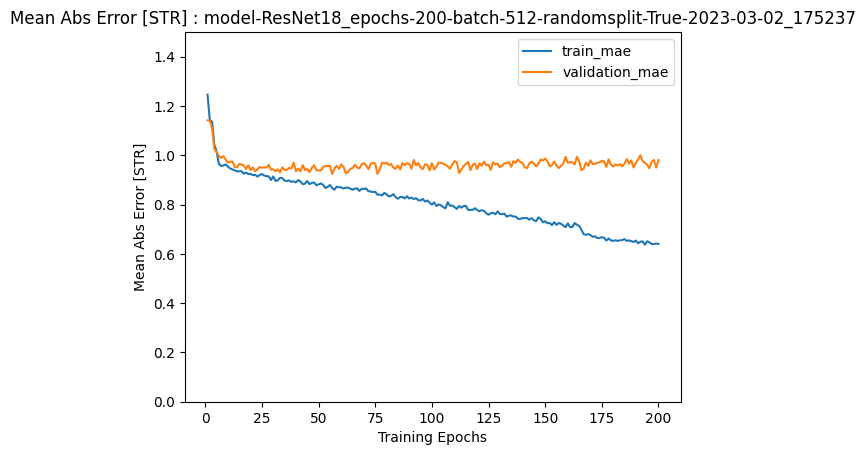

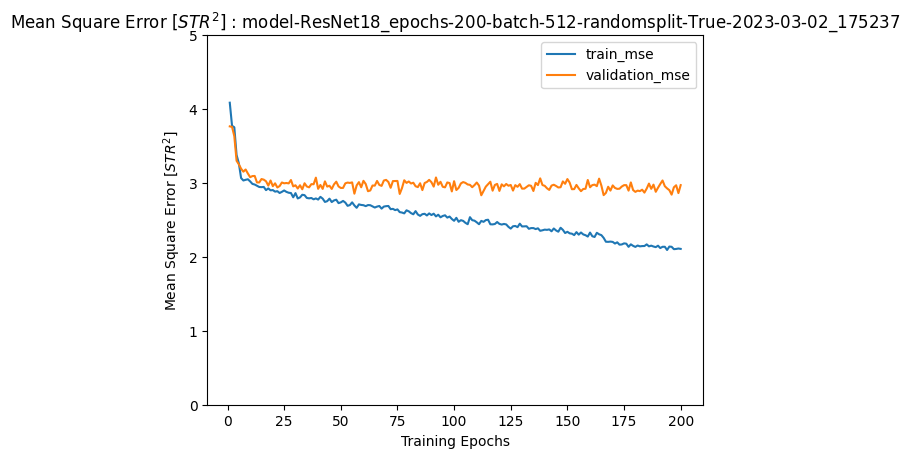

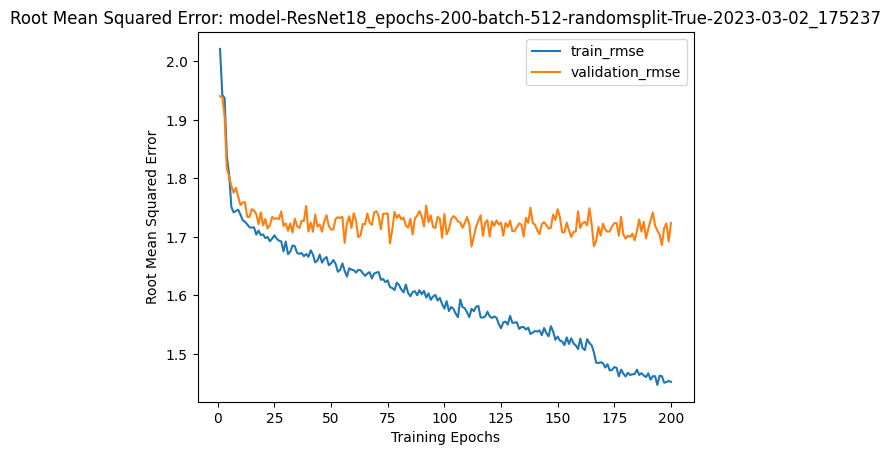

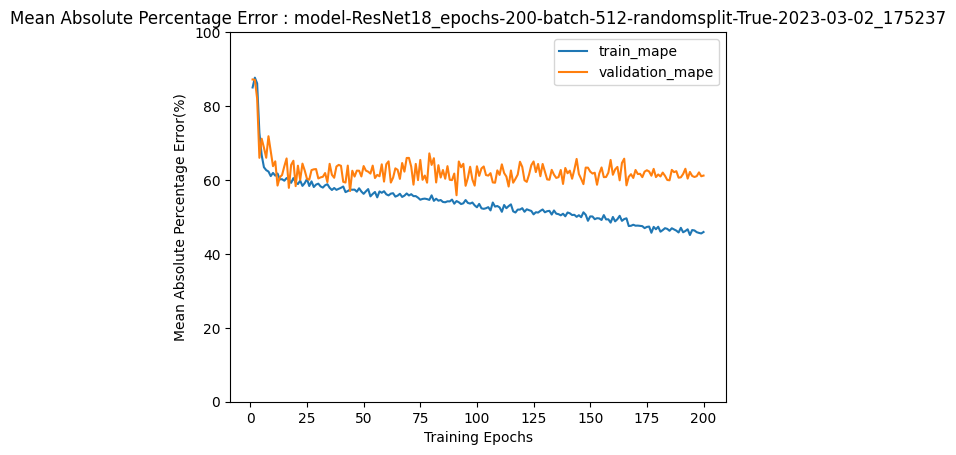

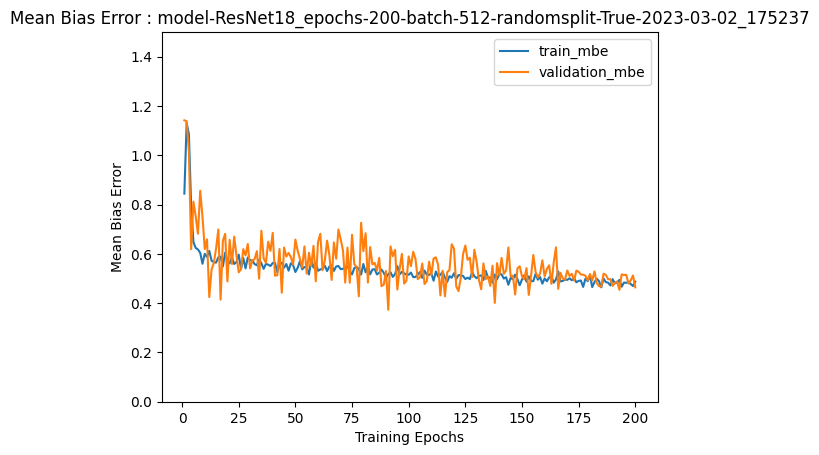

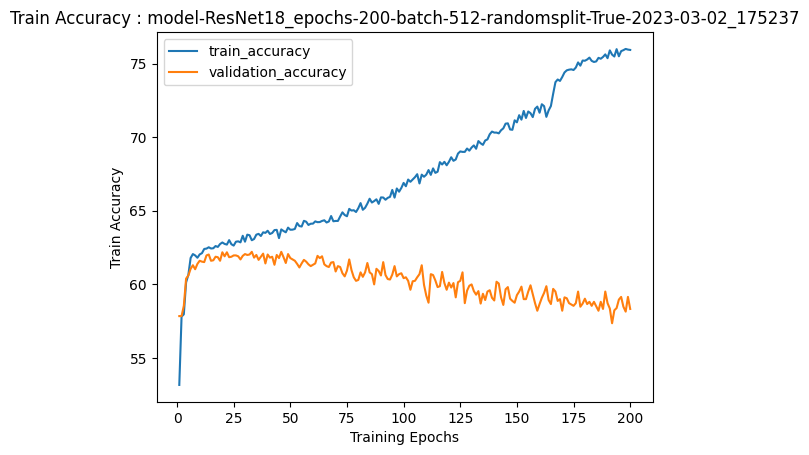

In [12]:
if web_running == True:
    plt.title("Mean Abs Error [STR] : {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),mae_history["train"],label="train_mae")
    plt.plot(range(1,EPOCHS+1),mae_history["val"],label="validation_mae")
    plt.ylabel("Mean Abs Error [STR]")
    plt.xlabel("Training Epochs")
    plt.ylim([0,1.5])
    plt.legend()
    plt.show()

    plt.title("Mean Square Error [$STR^2$] : {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),mse_history["train"],label="train_mse")
    plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation_mse")
    plt.ylabel("Mean Square Error [$STR^2$]")
    plt.xlabel("Training Epochs")
    plt.ylim([0,5])
    plt.legend()
    plt.show()

    plt.title("Root Mean Squared Error: {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),rmse_history["train"],label="train_rmse")
    plt.plot(range(1,EPOCHS+1),rmse_history["val"],label="validation_rmse")
    plt.ylabel("Root Mean Squared Error")
    plt.xlabel("Training Epochs")
    #plt.ylim([0,1.5])
    plt.legend()
    plt.show()

    plt.title("Mean Absolute Percentage Error : {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),mape_history["train"],label="train_mape")
    plt.plot(range(1,EPOCHS+1),mape_history["val"],label="validation_mape")
    plt.ylabel("Mean Absolute Percentage Error(%)")
    plt.xlabel("Training Epochs")
    plt.ylim([0,100])
    plt.legend()
    plt.show()

    plt.title("Mean Bias Error : {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),mbe_history["train"],label="train_mbe")
    plt.plot(range(1,EPOCHS+1),mbe_history["val"],label="validation_mbe")
    plt.ylabel("Mean Bias Error")
    plt.xlabel("Training Epochs")
    plt.ylim([0,1.5])
    plt.legend()
    plt.show()

    plt.title("Train Accuracy : {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),acc_history["train"],label="train_accuracy")
    plt.plot(range(1,EPOCHS+1),acc_history["val"],label="validation_accuracy")
    #plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation mse")
    plt.ylabel("Train Accuracy")
    plt.xlabel("Training Epochs")
    #plt.ylim([0,1.5])
    plt.legend()
    plt.show()

In [13]:
plt.clf()
plt.title("Mean Abs Error [STR] : {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),mae_history["train"],label="train_mae")
plt.plot(range(1,EPOCHS+1),mae_history["val"],label="validation_mae")
plt.ylabel("Mean Abs Error [STR]")
plt.xlabel("Training Epochs")
plt.ylim([0,1.5])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_mae_{}.png".format(hyperparameter_str), dpi=300)

plt.clf()
plt.title("Mean Square Error [$STR^2$] : {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),mse_history["train"],label="train_mse")
plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation_mse")
plt.ylabel("Mean Square Error [$STR^2$]")
plt.xlabel("Training Epochs")
plt.ylim([0,5])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_mse_{}.png".format(hyperparameter_str), dpi=300)

plt.clf()
plt.title("Root Mean Squared Error: {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),rmse_history["train"],label="train_rmse")
plt.plot(range(1,EPOCHS+1),rmse_history["val"],label="validation_rmse")
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Training Epochs")
#plt.ylim([0,1.5])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_rmse_{}.png".format(hyperparameter_str), dpi=300)

plt.clf()
plt.title("Mean Absolute Percentage Error : {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),mape_history["train"],label="train_mape")
plt.plot(range(1,EPOCHS+1),mape_history["val"],label="validation_mape")
plt.ylabel("Mean Absolute Percentage Error(%)")
plt.xlabel("Training Epochs")
plt.ylim([0,100])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_mape_{}.png".format(hyperparameter_str), dpi=300)

plt.clf()
plt.title("Mean Bias Error : {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),mbe_history["train"],label="train_mbe")
plt.plot(range(1,EPOCHS+1),mbe_history["val"],label="validation_mbe")
plt.ylabel("Mean Bias Error")
plt.xlabel("Training Epochs")
plt.ylim([0,1.5])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_mbe_{}.png".format(hyperparameter_str), dpi=300)

plt.clf()
plt.title("Train Accuracy : {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),acc_history["train"],label="train_accuracy")
plt.plot(range(1,EPOCHS+1),acc_history["val"],label="validation_accuracy")
#plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation mse")
plt.ylabel("Train Accuracy")
plt.xlabel("Training Epochs")
#plt.ylim([0,1.5])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_acc_{}.png".format(hyperparameter_str), dpi=300)

### 10. Using SHAP for XAI 

___Shap command has to been excuted by manually after training finishing(need time gap)___

In [14]:
df = pd.read_csv(data_path + 'amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized.csv')
dff = df.drop(['reviewNo', 'ReviewID', 'reviewStar', 'mGNR'], axis=1)

In [15]:
batch = next(iter(testloader))
images, _ = batch

#max_size = 100
max_size = 200
#max_size = BATCH_SIZE - 50
#max_size = 400
shap_test_size = max_size + 50

background = images[:max_size]
test_images = images[max_size:shap_test_size]

#e = shap.DeepExplainer(net, background.to(device))
e = shap.DeepExplainer(net, background.to(device))
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [16]:
shap.initjs()

shap.summary_plot(shap_values[0][0][0], images[:][0][0], feature_names=dff.columns)
shap.summary_plot(shap_values[0][0][0], images[:][0][0], feature_names=dff.columns,plot_type='bar')

i = 0

fig, axes = plt.subplots(3,3, figsize=(21,20))
for j in range(3,dff.shape[1]):
    _x = (j-3) / 3
    _x = math.floor(_x)
    _y = (j-3) % 3
    x_val = test_images_shap[:,0,:,j].ravel()
    y_val = shap_values_shap[0][:,0,:,j].ravel()
    col = np.where(y_val<0,'deeppink', 'mediumblue')
    axes[_x][_y].scatter(x_val, y_val, s=3, c=col)
    ylabel_str = "SHAP value for\n" + dff.columns[i]
    axes[_x][_y].set_xlabel(dff.columns[j], fontsize=20)
    axes[_x][_y].set_ylabel(ylabel_str, fontsize=20)
    axes[_x][_y].set_ylim([-1, 1])
    axes[_x][_y].tick_params(labelsize=15)
axes[2][2].set_visible(False)
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.suptitle(f"SHAP analysis for rating \'{i+1}\'", fontsize=45, y=0.94)
plt.show()

In [18]:
print('-- Building shap test dataset / dataloader--')
for i in range(5):
    dataset_shap = MDSMDataset(f'{data_path}amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized_reviewStar{i+1}.csv')
    print(f'{data_path}amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized_reviewStar{i+1}.csv is used for shap analysis')

    shap_shap_loader = torch.utils.data.DataLoader(dataset_shap, batch_size = len(dataset_shap), shuffle=True, num_workers=0)

    batch_shap = next(iter(shap_shap_loader))
    images_shap, _ = batch_shap

    max_size_shap = len(dataset_shap)
  
    test_images_shap = images_shap[:max_size_shap]
    shap_values_shap = e.shap_values(test_images_shap)
    
    clear_output(wait=True)
    print(f'{data_path}amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized_reviewStar{i+1}.csv is used for shap analysis')
    
    plt.clf()
    fig, axes = plt.subplots(3,3, figsize=(21,20))
    for j in range(3,dff.shape[1]):
        _x = (j-3) / 3
        _x = math.floor(_x)
        _y = (j-3) % 3
        x_val = test_images_shap[:,0,:,j].ravel()
        y_val = shap_values_shap[0][:,0,:,j].ravel()
        col = np.where(y_val<0,'deeppink', 'mediumblue')
        axes[_x][_y].scatter(x_val, y_val, s=3, c=col)
        ylabel_str = "SHAP value for\n" + dff.columns[i]
        axes[_x][_y].set_xlabel(dff.columns[j], fontsize=20)
        axes[_x][_y].set_ylabel(ylabel_str, fontsize=20)
        axes[_x][_y].set_ylim([-1, 1])
        axes[_x][_y].tick_params(labelsize=15)
    axes[2][2].set_visible(False)
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    plt.suptitle(f"SHAP analysis for rating \'{i+1}\'", fontsize=45, y=0.94)
    #plt.show()
    plt.savefig("{}graphs/amazon_hmdvr_df_tokenized_sentiment_score_shap-data_{}-{}_{}.png"
            .format(path, i+1, max_size, hyperparameter_str), dpi=300)
    print("{}graphs/amazon_hmdvr_df_tokenized_sentiment_score_shap-data_{}-{}_{}.png is saved"
            .format(path, i+1, max_size, hyperparameter_str))
    
    #shap.summary_plot(shap_values_shap[0][0][0], images_shap[:][0][0], feature_names=dff.columns)
    #shap.summary_plot(shap_values_shap[0][0][0], images_shap[:][0][0], feature_names=dff.columns,plot_type='bar')
    
    #plt.clf()
    #shap.summary_plot(shap_values_shap[0][0][0], images_shap[:][0][0], feature_names=dff.columns,show=False)
    #plt.savefig("{}graphs/amazon_hmdvr_df_tokenized_sentiment_score_shap_summary-data_{}-{}_{}.png"
    #        .format(path, i+1, max_size, hyperparameter_str), dpi=300)
    #print("{}graphs/amazon_hmdvr_df_tokenized_sentiment_score_shap_summary-data_{}-{}_{}.png is saved"
    #        .format(path, i+1, max_size, hyperparameter_str))
    
    #plt.clf()
    #shap.summary_plot(shap_values_shap[0][0][0], images_shap[:][0][0], feature_names=dff.columns,plot_type='bar',show=False)
    #plt.savefig("{}graphs/amazon_hmdvr_df_tokenized_sentiment_score_shap_summary-bar-data_{}-{}_{}.png"
    #        .format(path, i+1, max_size, hyperparameter_str), dpi=300)
    #print("{}graphs/amazon_hmdvr_df_tokenized_sentiment_score_shap_summary-bar-data_{}-{}_{}.png is saved"
    #        .format(path, i+1, max_size, hyperparameter_str))

amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized_reviewStar5.csv is used for shap analysis
results/2023-03-02_175237_jupyter/graphs/amazon_hmdvr_df_tokenized_sentiment_score_shap-data_5-200_model-ResNet18_epochs-200-batch-512-randomsplit-True-2023-03-02_175237.png is saved


In [ ]:
print_out_hyperparameter()